# Capstone 2 Project - Russian Troll Groups - Fearmonger

In the analysis of each troll group, each of the troll groups* will be segmented out and analyzed each individually.  The "troll classes", as defined by Clemson University's Darren Linvill and Patrick Warren in their analysis of the Russian Troll Farm Twitter data.

I will analyze the Troll Groups to explore questions about the nature of the disinformation campaign, such as:
* Did other trolls retweet and amplify troll tweets?
* Can common topics or themes be identified?
* What were the most-used hashtags?
* Did the tweets predominantly support one candidate or political party, or seek to undermine the other?

## Data Dictionary

Header | Definition
-------|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?   id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018

In [2]:
# import standard libraries
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#import numpy as np
#import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
#get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
# import nltk libraries
from nltk.corpus import stopwords
from nltk import FreqDist
#nltk.download('stopwords') # run one time

In [4]:
# import gensim libraries
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import datapath
from gensim import corpora
from gensim.utils import any2unicode

In [5]:
#suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# encoding='utf-8',
#right_troll = pd.read_csv('../data/right_troll.csv', parse_dates = ['publish_date'], low_memory=False)
#nonenglish = pd.read_csv('../data/nonenglish.csv', parse_dates = ['publish_date'], low_memory=False)
#fearmonger = pd.read_csv('../data/fearmonger.csv', parse_dates = ['publish_date'], low_memory=False)
#left_troll = pd.read_csv('../data/left_troll.csv', parse_dates = ['publish_date'], low_memory=False)
#hashtagamer = pd.read_csv('../data/hashtagamer.csv', parse_dates = ['publish_date'], low_memory=False)
#newsfeed = pd.read_csv('../data/newsfeed.csv', parse_dates = ['publish_date'], low_memory=False)
#commercial = pd.read_csv('../data/commercial.csv', parse_dates = ['publish_date'], low_memory=False)
# print(df.shape)

In [7]:
# read each troll classification file as 'df', for repurposing code for each class
# nrows=100, 
full_df = pd.read_csv('../data/all_IRAhandle_tweets.csv', parse_dates = ['publish_date'], low_memory=False)
name = 'Right Troll'

In [8]:
full_df['account_category'].unique()

array(['RightTroll', 'NonEnglish', 'Fearmonger', 'LeftTroll', 'Unknown',
       'HashtagGamer', 'NewsFeed', 'Commercial'], dtype=object)

In [9]:
df = full_df[full_df['account_category'] == "Fearmonger"]

In [10]:
#Explicitly state that DF is a copy of full_df
df.is_copy = True
#df.drop('Unnamed: 0', axis=1, inplace=True)
# drop rows with problematic character encoding
#df.drop([58, 59], axis=0, inplace=True)
#df.head()

In [11]:
df['cleaned'] = df['content'].fillna('').astype(str).map(any2unicode)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Text Preprocessing
* Noise Removal
* Tokenization
* Normalization  
(1) stemming
(2) lemmatization, and 
(3) everything else

### Remove URLs and non-English Characters

In [12]:
def preprocess_text(text):
    '''Remove URLs and Non-English characters, except for @ and #'''
    # remove URL's
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    # remove symbols excluding the @, # and \s symbol
    text = re.sub(r'[^\w@#\s]', '', text)

    # remove URL's
    text = re.sub('(https://[^\s]+)', '', text)
    text = re.sub('https?://[A-Za-z0-9./]+', '', text)

    # remove URL's
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)

    # lowercase, remove words less than len 2 & remove numbers in tokenized list
    #return [word.lower() for word in text if len(word) > 2 and not word.isdigit() and not word in ignore_words]
    return text

In [13]:
df['cleaned'] = df['cleaned'].apply(preprocess_text)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Hashtag Analysis

In [14]:
# regex to find hashtags
hashtag_re = re.compile("(?:^|\s)[＃#]{1}(\w+)", re.UNICODE)

def extract_hashtags(tweet):
    '''Take in tweet contents from 'cleaned' content, extract hashtags and return cleaned text'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        hashtags_only.append(re.findall(hashtag_re, tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

In [15]:
# Create a new column to store hashtags, extract hashtags from 'content'
df['hashtags'] = df['cleaned'].map(extract_hashtags)
df['hashtags'].head(25)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


424    [FoodPoisoning, Walmart, KochFarms]
425                    [turkey, KochFarms]
426                                    [0]
427                                    [0]
428                                    [0]
429                                    [0]
430                                    [0]
431                                    [0]
432                                    [0]
433                                    [0]
434                                    [0]
435                                    [0]
436                                    [0]
437                          [JasonAldean]
438                                    [0]
439                                    [0]
440                                    [0]
441                                    [0]
442                                    [0]
443                                    [0]
444                                    [0]
445                                    [0]
446                                    [0]
447        

In [16]:
# remove all hashtags from a tweet
def remove_hashtags(tweet):
    '''After extracting hashtags, take in tweet content and remove hashtags'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        tweet = re.sub(hashtag_re, "", tweet)
    hashtags_only.append(tweet)
    return hashtags_only[0]

In [17]:
# Clean hashtags fron 'cleaned' content
df['cleaned'] = df['cleaned'].apply(remove_hashtags)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
# create a list of all hashtags
all_hashtags = df['hashtags'].tolist()

# all_hashtags is a list of lists.
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_hashtags list
cleaned_hashtags = remove_values_from_list(cleaned_hashtags, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()
print(hashtag_counts[:25])

0                    4826
KochFarms            3210
USDA                 1393
Turkey               1076
DemnDebate           1016
Walmart               813
turkey                764
NY                    729
FoodPoisoning         682
FSIS                  595
DogThanking           577
foodpoisoning         500
ImThankfulFor         460
DemDebate             367
NewYork               319
Fail                  280
kochfarms             253
thanksgiving          239
Thanksgiving          152
FergusonRemembers     149
walmart               140
fail                  133
DEMDebate             130
NYC                    86
MikeBrown              82
dtype: int64


### Get User Mentions

In [19]:
#Regex to get user mentions "@":
# New Regex
twitter_username_re = re.compile("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", re.UNICODE)

def extract_usermentions(tweet):
    '''Take in tweet contents from 'cleaned' col and extract user mentions'''
    mentions_only = []
    if len(re.findall(twitter_username_re, tweet)) > 0:
        mentions_only.append(re.findall(twitter_username_re, tweet))
    else:
        mentions_only.append(["0"])
    return mentions_only[0]

In [20]:
# make a new column to store the extracted mentions
df['mentions'] = df['cleaned'].map(extract_usermentions)
df['mentions'].head(10)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


424                [is]
425                 [0]
426                 [0]
427                 [0]
428                 [0]
429                 [0]
430                 [0]
431    [The, Aristotle]
432                 [0]
433                 [0]
Name: mentions, dtype: object

In [21]:
# create a list of all mentions
all_mentions = df['mentions'].tolist()

# all_hashtags is a list of lists.
cleaned_mentions = []
for i in all_mentions:
    for j in i:
            cleaned_mentions.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_mentions list
cleaned_mentions = remove_values_from_list(cleaned_mentions, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_mentions_series = pd.Series(cleaned_mentions)
mention_counts = cleaned_mentions_series.value_counts()
# remove first element with values of '0'
# mention_counts = del mention_counts[0]
print(mention_counts[:25])

0               5979
This             103
I                103
Thanks            95
Thats             93
is                88
What              83
Thanksgiving      75
the               63
The               55
Poisoned          52
Well              50
my                49
How               48
whats             42
These             42
Very              39
Dont              37
this              37
We                36
Page              35
My                33
Oh                32
You               32
People            31
dtype: int64


In [22]:
# remove all mentions from a tweet
def remove_mentions(tweet):
    '''Take tweet content and remove @mentions from it'''
    mentions_only = []
    if len(re.findall("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", tweet)) > 0:
        tweet = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", "", tweet)
    mentions_only.append(tweet)
    return mentions_only[0]

In [23]:
#create list of content with no hashtags
df['cleaned'] = df['cleaned'].apply(remove_mentions)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
# remove unwanted characters, numbers and symbols from the remaining content
#df['cleaned'] = df['cleaned'].str.replace("[^a-zA-Z#]", " ")

### Create dataframes for the troll classifications
Create dataframes for each troll classification, for easier size to work with.

In [25]:
#right_troll = df.loc[df['account_category'] == 'RightTroll']
#nonenglish = df.loc[df['account_category'] == 'NonEnglish']
#fearmonger = df.loc[df['account_category'] == 'Fearmonger']
#left_troll = df.loc[df['account_category'] == 'LeftTroll']
#hashtagamer = df.loc[df['account_category'] == 'HashtagGamer']
#newsfeed = df.loc[df['account_category'] == 'NewsFeed']
#commercial = df.loc[df['account_category'] == 'Commercial']

In [26]:
#right_troll.to_csv("../data/right_troll.csv")
#nonenglish.to_csv("../data/nonenglish.csv")
#fearmonger.to_csv("../data/fearmonger.csv")
#left_troll.to_csv("../data/left_troll.csv")
#hashtagamer.to_csv("../data/hashtagamer.csv")
#newsfeed.to_csv("../data/newsfeed.csv")
#commercial.to_csv("../data/commercial.csv")

## Remove stopwords
Remove words < 3 letters, convert to lower case

In [27]:
df.cleaned.head()

424                                                              is not a joke  
425                                Thanks God that i ate few days ago was good  
426    I hurt easy I just dont show it You can hurt someone and not even know it
427                                                       Kim and kanye wedding 
428                          whos got the worst make up ever dont tell me mirror
Name: cleaned, dtype: object

In [28]:
# remove short words (length < 3)
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# transform to lower-case
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#train['tweet'].head()

#stop = set(stopwords.words('english'))
stop = stopwords.words('english')

#extend/add to stopwords - words that are commonly occuring but add no meaning
#stopword_list += ['http', 'https', 'âµã', 'â½ã', 'â²ã', 'âºã', 'â¼ã', 'âµ']
newStop = ['you','get', 'amp', 'one', 'new']
stop.extend(newStop)

df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['cleaned'].head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

424                                          joke
425                  thanks god ate days ago good
426    hurt easy dont show hurt someone even know
427                             kim kanye wedding
428     whos got worst make ever dont tell mirror
Name: cleaned, dtype: object

In [29]:
#convert 'cleaned' Series to a list
content = df['cleaned'].tolist()
#content[:50]

### Re-Check Fequency Distribution
Re-check the word frequency distribution after doing some cleaning of the text.

In [30]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    ''' Take in a list of content, split into individual words, count occurrences, list 20 highest occurring words'''
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    return d

In [31]:
counts = freq_words(content, 20)
print(counts)

              word  count
185   thanksgiving    961
209            omg    743
222          wooow    697
144          happy    629
151         people    486
9             dont    419
61            like    316
233       poisoned    315
461          thats    260
4316        ashley    229
4317       madison    221
247         turkey    203
1236         trump    203
2              god    202
1203          york    198
148           want    189
1           thanks    185
390            day    180
403           time    179
6             good    177


### Plot most frequently occurring words 

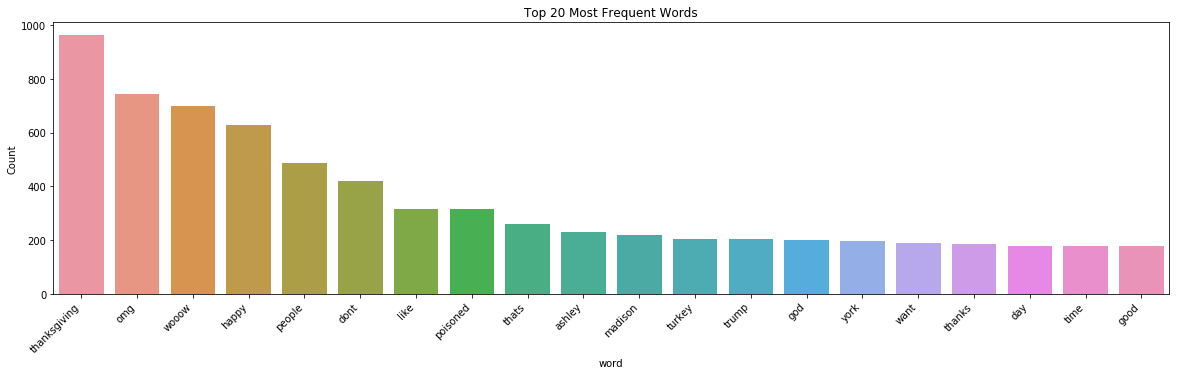

In [32]:
# Plot most frequent words
plt.figure(figsize=(20,5))
# rotate and right align group names
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(data=counts, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Top 20 Most Frequent Words')    
plt.show()

## Troll Amplification
Examining the troll "echo chamber". Are trolls retweeting or mentioning other trolls?

In [33]:
# read list of users created during EDA
users = pd.read_csv('../data/users_totals.csv', encoding='utf-8',low_memory=False)

userlist = users['author'].tolist()
lc_userlist = [x.lower() for x in userlist]
lc_userlist.sort()

amplify = cleaned_mentions_series[cleaned_mentions_series.isin(lc_userlist)]

print(amplify.shape[0])

# Get counts of amplified troll tweets
amp_counts = amplify.value_counts()
print("There are",(amplify.shape[0]), "trolls in the echo chamber.")

3
There are 3 trolls in the echo chamber.


### Normalization
3 distinct steps:  
* stemming  
* lemmatization  
* everything else

### Lemmatization

In [34]:
from textblob import Word
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['cleaned'].head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


424                                          joke
425                   thanks god ate day ago good
426    hurt easy dont show hurt someone even know
427                             kim kanye wedding
428      who got worst make ever dont tell mirror
Name: cleaned, dtype: object

### Tokenize

In [35]:
#create a list from df['cleaned']
content_notags = df['cleaned'].tolist()

# First, create a new column with the tokenized text
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
#df['tokenized_text'] = df['content'].apply(tt.tokenize)
# map tt.tokenize to 'content' list
documents = list(map(tt.tokenize, content_notags))

In [36]:
from collections import defaultdict

frequency = defaultdict(int)
for document in documents:
    for token in document:
        frequency[token] += 1

In [37]:
documents = [[token for token in document if frequency[token] > 10] for document in documents]
# create a dictionary using from gensim.corpora.Dictionary
dictionary = corpora.Dictionary(documents)
#Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 
corpus = [dictionary.doc2bow(document) for document in documents]

In [38]:
len(corpus)

11140

## LDA Model
Fit an LDA Model for the tweet topics

In [39]:
# comment out once model is trained.
# fit LDA model
tweet_topics = LdaMulticore(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          passes=10,
                          workers=2)

In [40]:
# save/load model to/from disk

temp_file = datapath("model_right_troll_tweets")
tweet_topics.save(temp_file)

# Load a pretrained model from disk.
#tweet_topics = LdaMulticore.load("model")
# - or -
#m1 = LdaMulticore.load(datapath("lda_3_0_1_model"))

In [41]:
# print out first 10 topics
for i, topic in enumerate(tweet_topics.print_topics(10)):
    print('{} --- {}'.format(i, topic))

0 --- (0, '0.044*"dont" + 0.039*"want" + 0.027*"year" + 0.026*"eat" + 0.023*"problem" + 0.020*"america" + 0.019*"tell" + 0.017*"car" + 0.017*"candidate" + 0.017*"attack"')
1 --- (1, '0.051*"love" + 0.029*"koch" + 0.024*"would" + 0.023*"make" + 0.021*"omg" + 0.020*"best" + 0.019*"thing" + 0.018*"debate" + 0.016*"nice" + 0.014*"wish"')
2 --- (2, '0.164*"thanksgiving" + 0.106*"happy" + 0.087*"wooow" + 0.053*"poisoned" + 0.049*"omg" + 0.026*"thanks" + 0.017*"people" + 0.017*"kill" + 0.014*"fuck" + 0.013*"well"')
3 --- (3, '0.040*"thats" + 0.030*"omg" + 0.027*"way" + 0.025*"see" + 0.023*"deal" + 0.023*"gonna" + 0.022*"going" + 0.021*"wooow" + 0.018*"good" + 0.017*"take"')
4 --- (4, '0.052*"like" + 0.039*"time" + 0.026*"trump" + 0.022*"look" + 0.022*"right" + 0.020*"square" + 0.017*"donald" + 0.017*"woman" + 0.016*"topless" + 0.015*"cant"')
5 --- (5, '0.040*"god" + 0.039*"day" + 0.034*"friend" + 0.029*"good" + 0.019*"york" + 0.018*"real" + 0.018*"prison" + 0.018*"sweat" + 0.017*"david" + 0.0

### Wordcloud
Crate a basic word cloud of the topic groupings

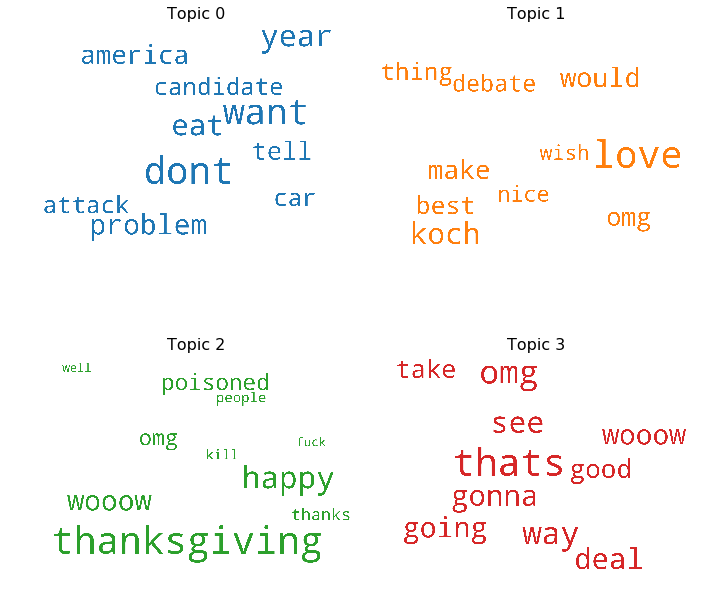

In [42]:
#Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = tweet_topics.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Use pyLDAvis library to Visualize Topics

In [43]:
## Try the pyLDAvis visualization
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [44]:
# http://tlfvincent.github.io/2015/10/23/presidential-speech-topics/#topic=1&lambda=1&term=
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)
pyLDAvis.display(vis_data)

### Output Visualization Tool to HTML

In [46]:
# save viz output to an HTML file
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)

pyLDAvis.save_html(vis_data, 'pyLDAviz_Fearmonger.html')